# TABLE OF CONTENT

[I. IMPORT NECESSARY LIBRARIES](#i-import-necessary-libraries)

[II. LOADING DATASET](#ii-loading-dataset)

[III. EXPLORATORY DATA ANALYSIS (EDA)](#iii-exploratory-data-analysis-eda)

  [1) Dataset overview](#1-dataset-overview)

  [2) Add `image_path` Column](#2-add-image_path-column)

  [3) ]

# I. IMPORT NECESSARY LIBRARIES

In [ ]:
# Data manipulation libraries
import pandas as pd
import numpy as np
import random
import cv2
import os
from tqdm import tqdm
from collections import defaultdict
import imagehash

# Data visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Image Visualization
import matplotlib.image as mpimg
from PIL import Image

# Data preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize

# Sklearn Library
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
    roc_curve, auc,
)





## Import Tensorflow for TensorFlow ≤ 2.12

In [ ]:
# Deep learning libraries
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.initializers import GlorotUniform
from tensorflow.keras.layers import Conv2D, MaxPooling2D

# Transfer learning models
from tensorflow.keras.applications import EfficientNetB0, ResNet50
from tensorflow.keras import models

## Using Keras for Keras 3.x with TensorFlow ≥ 2.13

In [ ]:
# Deep learning libraries
import tensorflow as tf
from keras import Sequential, layers, models, Input
from keras.regularizers import l2
from keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.src.legacy.preprocessing.image import ImageDataGenerator
from keras.initializers import GlorotUniform

# Transfer learning models
from keras.applications import EfficientNetB0, ResNet50
from keras import models

# II. LOADING DATASET

In [6]:
df = pd.read_csv('./inputs/training_df.csv')
df

image_id                  label variety  age  \
0      100330.jpg  bacterial_leaf_blight   ADT45   45   
1      100365.jpg  bacterial_leaf_blight   ADT45   45   
2      100382.jpg  bacterial_leaf_blight   ADT45   45   
3      100632.jpg  bacterial_leaf_blight   ADT45   45   
4      101918.jpg  bacterial_leaf_blight   ADT45   45   
...           ...                    ...     ...  ...   
10402  107607.jpg                 tungro   Zonal   55   
10403  107811.jpg                 tungro   Zonal   55   
10404  108547.jpg                 tungro   Zonal   55   
10405  110245.jpg                 tungro   Zonal   55   
10406  110381.jpg                 tungro   Zonal   55   

                                              image_path  
0      ./inputs/train_images\bacterial_leaf_blight\10...  
1      ./inputs/train_images\bacterial_leaf_blight\10...  
2      ./inputs/train_images\bacterial_leaf_blight\10...  
3      ./inputs/train_images\bacterial_leaf_blight\10...  
4      ./inputs/train_images\bacterial_leaf_blight\10...  
...                                                  ...  
10402            ./inputs/train_images\tungro\107607.jpg  
10403            ./inputs/train_images\tungro\107811.jpg  
10404            ./inputs/train_images\tungro\108547.jpg  
10405            ./inputs/train_images\tungro\110245.jpg  
10406            ./inputs/train_images\tungro\110381.jpg  

[10407 rows x 5 columns]

# IV. MODEL TRAINING

To ensure that the results are stable for multiple run time, we setup the seed for dataset

In [7]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

## 1) Helper Functions

In [19]:
def visualize_category_distribution(df, column_name):
    """
    Visualizes the distribution of categories from a specified column in the provided DataFrame.

    Parameters:
    - df: pandas DataFrame containing the column to visualize.
    - column_name: The column name whose distribution will be visualized.
    """
    # Calculate the frequency of each category in the specified column
    category_counts = df[column_name].value_counts()

    # Create a figure with two side-by-side plots
    fig, axes = plt.subplots(1, 2, figsize=(20, 10), facecolor="white")

    # Plot a pie chart in the first subplot
    color_palette = sns.color_palette("coolwarm")
    sns.set_palette(color_palette)
    axes[0].pie(
        category_counts, labels=category_counts.index, autopct="%1.1f%%", startangle=140
    )
    axes[0].set_title(f"{column_name} Distribution")

    # Plot a bar chart in the second subplot with the hue parameter
    sns.barplot(
        x=category_counts.index,
        y=category_counts.values,
        ax=axes[1],
        hue=category_counts.index,
        palette="coolwarm",
        legend=False,
    )
    axes[1].set_title(f"{column_name} Counts")

    # Adjust layout to ensure no overlapping of elements
    plt.tight_layout()

    # Display the plots
    plt.show()

In [15]:
def print_header(content, padding=10, width=None, tabs=False):
    """
    Prints a header wrapped inside a box.

    Parameters:
    - content: Text to display as header (automatically uppercase)
    - padding: Spaces on each side of the content inside the box
    - width: Optional fixed width for the entire box. If None, adjusts to content size.
    - tabs: If true, adds the spacing `\t`to center of the box
    """
    content = content.upper()
    inner_width = len(content) + (padding * 2)
    box_width = width if width and width > inner_width else inner_width

    top_bottom = "+" + "-" * (box_width + 2) + "+"
    padded_content = "| " + content.center(box_width) + " |"
    prefix = "\t" * 3 if tabs else ""

    print(f"{prefix}{top_bottom}")
    print(f"{prefix}{padded_content}")
    print(f"{prefix}{top_bottom}")

In [8]:
def plot_learning_curve(train_loss, val_loss, train_metric, val_metric, metric_name='Accuracy'):

    plt.figure(figsize=(20,10))
    
    plt.subplot(1,2,1)
    plt.plot(train_loss, 'r--')
    plt.plot(val_loss, 'b--')
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.legend(['train', 'val'], loc='upper left')

    plt.subplot(1,2,2)
    plt.plot(train_metric, 'r--')
    plt.plot(val_metric, 'b--')
    plt.xlabel("epochs")
    plt.ylabel(metric_name)
    plt.legend(['train', 'val'], loc='upper left')

    plt.show()

## 3) Task 2: Variety Classification

### 3.1) Helper Functions

In [9]:
def apply_img_cutout(image, percentage=0.2, rng=None):
    """
    Cut the image based on the percentage

    - image: the image to cut
    - percentage: the percentage of cutout
    - rng: Random number generator for reproducibility.
    """

    h, w = image.shape[:2]
    cutout_size_h = int(h * percentage)
    cutout_size_w = int(w * percentage)

    # Random position for cutout
    x = rng.randint(0, w - cutout_size_w)
    y = rng.randint(0, h - cutout_size_h)

    # Create copy of the image
    img_cutout = image.copy()
    img_cutout[y : y + cutout_size_h, x : x + cutout_size_w] = 0

    return img_cutout

In [10]:
def zoom_in_crop(image, zoom_factor=1.2):
    """
    Zoom in on the image by cropping the edges and resizing back to original size

    - image: the image file
    - zoom_factor: the zoom ratio
    """
    h, w = image.shape[:2]

    # Calculate crop dimensions
    crop_h = int(h / zoom_factor)
    crop_w = int(w / zoom_factor)

    # Calculate offsets to center the crop
    start_y = (h - crop_h) // 2
    start_x = (w - crop_w) // 2

    # Crop and resize
    cropped = image[start_y : start_y + crop_h, start_x : start_x + crop_w]
    zoomed = cv2.resize(cropped, (w, h), interpolation=cv2.INTER_LINEAR)

    return zoomed

In [11]:
def random_crop_resize(image, crop_percent=0.8, rng=None):
    """
    Random crop of the image followed by resize to original dimensions

    - image: input image
    - crop_percent: Percentage of the image to keep
    - rng: Random number generator for reproducibility.
    """
    if rng is None:
        rng = np.random

    h, w = image.shape[:2]
    crop_h = int(h * crop_percent)
    crop_w = int(w * crop_percent)

    # Random starting point for crop
    start_y = rng.randint(0, h - crop_h + 1)
    start_x = rng.randint(0, w - crop_w + 1)

    # Crop and resize
    cropped = image[start_y : start_y + crop_h, start_x : start_x + crop_w]
    resized = cv2.resize(cropped, (w, h), interpolation=cv2.INTER_LINEAR)

    return resized

In [12]:
def rotate_image(image, angle):
    """
    Rotates an image by the specified angle.

    Parameters:
    - image: Input image
    - angle: Array of angles in degrees

    Returns:
    - Rotated image with the same dimensions as input
    """
    # Get image dimensions and center
    height, width = image.shape[:2]
    center = (width // 2, height // 2)

    # Calculate rotation matrix
    rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)

    # Apply rotation while maintaining original dimensions
    rotated = cv2.warpAffine(
        image,
        rotation_matrix,
        (width, height),
        flags=cv2.INTER_LINEAR,
        borderMode=cv2.BORDER_REFLECT,  # Avoid black borders
    )

    return rotated

In [13]:
def df_augmentation(
    df,
    output_csv_path="./inputs/meta_train_augmented.csv",
    img_augmented_dir="./inputs/train_augmented_images",
    random_state=42,
):
    """
    Augments underrepresented paddy varieties using various image transformations.

    Parameters:
    - df: Original dataFrame containing image metadata
    - output_csv_path: Path to save the augmented metadata CSV
    - img_original_dir: Directory containing original images
    - img_augmented_dir: Directory to save augmented images
    - random_state: Seed for reproducible augmentations

    Returns:
    - augmented_df: DataFrame containing original and augmented image metadata
    - augmented_count: Dictionary counting new images per variety
    """
    # Fixed seed RNG for consistent augmentations
    rng = np.random.RandomState(random_state)

    # ensure that the img_augmented_dir exists
    os.makedirs(img_augmented_dir, exist_ok=True)

    target_varieties = df["variety"].value_counts()

    # Create new rows for augmented images
    new_rows = []
    augmented_count = defaultdict(int)

    # Define augmentation strategies based on variety count
    VERY_LOW_COUNT = 50
    LOW_COUNT = 120
    MID_LOW_COUNT = 400
    MID_COUNT = 1000

    for _, row in tqdm(df.iterrows(), total=len(df), desc="Generating augmentations"):
        image_id, label, variety, age = (
            row["image_id"],
            row["label"],
            row["variety"],
            row["age"],
        )

        # Get image path
        image_path = row["image_path"]

        variety_count = target_varieties[variety]

        # if the current variety count exceeds the MID_COUNT (1000) already -> skip
        if variety_count > MID_COUNT:
            continue

        # if the path doesn't exist
        if not os.path.exists(image_path):
            print(f"[ERROR] Invalid image path: {image_path}")
            continue

        image = cv2.imread(image_path)

        if image is None:
            print(f"[ERROR] Failed to load image: {image_path}")
            continue

        augmentations = []

        # For very low count (<=50)
        if variety_count < VERY_LOW_COUNT:
            # Rotations augmentations
            for angle in [-15, -10, -5, 5, 10, 15]:
                rotated = rotate_image(image, angle)
                augmentations.append((f"rot_{angle}", rotated))

            # Horizontal flip
            augmentations.append(("hflip", cv2.flip(image, 1)))

            # Vertical flip
            augmentations.append(("vflip", cv2.flip(image, 0)))

            # Brightness adjustment positive_20 and negative_20(+20% and -20%)
            augmentations.append(
                ("bright_p20", cv2.convertScaleAbs(image, alpha=1.2, beta=0))
            )
            augmentations.append(
                ("bright_n20", cv2.convertScaleAbs(image, alpha=0.8, beta=0))
            )

            # Zoom-in crop
            augmentations.append(("zoom", zoom_in_crop(image)))

            # Cutout
            augmentations.append(("cutout", apply_img_cutout(image, rng=rng)))

        # Low count variety (< 100)
        elif variety_count < LOW_COUNT:
            # Apply rotations
            for angle in [-10, -5, 5, 10]:
                rotated = rotate_image(image, angle)
                augmentations.append((f"rot_{angle}", rotated))

            # Brightness adjustments (+20% and -20%)
            augmentations.append(
                ("bright_p20", cv2.convertScaleAbs(image, alpha=1.2, beta=0))
            )
            augmentations.append(
                ("bright_n20", cv2.convertScaleAbs(image, alpha=0.8, beta=0))
            )

        # Lower than 400
        elif variety_count < MID_LOW_COUNT:
            # Limited rotations
            for angle in [-5, 5]:
                rotated = rotate_image(image, angle)
                augmentations.append((f"rot_{angle}", rotated))

            # Random crop and resize
            augmentations.append(("crop_resize", random_crop_resize(image, rng=rng)))

        # Lower than 800 counts
        elif variety_count < MID_COUNT:
            for angle in [-5, 5]:
                rotated = rotate_image(image, angle)
                augmentations.append((f"rot_{angle}", rotated))

        # Apply all selected augmentations
        for aug_name, aug_img in augmentations:
            # Extract base name without extension
            base_name = os.path.splitext(image_id)[0]

            new_image_id = f"{base_name}_{aug_name}.jpg"

            label_dir = os.path.join(img_augmented_dir, label)
            os.makedirs(label_dir, exist_ok=True)

            new_path = os.path.join(label_dir, f"{new_image_id}")

            # If the image file doesn't exist
            if not os.path.exists(new_path):
                cv2.imwrite(new_path, aug_img)

            new_rows.append(
                {
                    "image_id": new_image_id,
                    "label": label,
                    "variety": variety,
                    "age": age,
                    "image_path": new_path,
                }
            )
            augmented_count[variety] += 1

    # Create augmented DataFrame
    augmented_df = pd.concat([df, pd.DataFrame(new_rows)], ignore_index=True)

    # Save augmented metadata
    augmented_df.to_csv(output_csv_path, index=False)

    print_header("Augmentation Summary")
    print(f"Original dataset: {len(df)} images")
    print(f"Augmented dataset: {len(augmented_df)} images")
    print(f"Added {len(new_rows)} augmented images")

    return augmented_df, augmented_count

In [16]:
def display_augmentation_examples(
    original_df,
    augmented_df,
    tiers,
    augmentations,
):
    """
    Display examples of each type of augmentation applied to images from different variety tiers

    Parameters:
    - original_df: original DataFrame metadata
    - augmented_df: augmented DataFrame metadata
    - tiers: Dictionary mapping tier names to lists of variety names belonging to that tier
    - augmentations: Dictionary mapping tier names to lists of augmentation types applied to that tier
    """
    for tier_name, varieties in tiers.items():
        if not varieties:
            continue

        # Take the first variety in this tier
        variety = varieties[0]

        # Find an example image for this variety
        sample_row = original_df[original_df["variety"] == variety].iloc[0]
        original_image_id = sample_row["image_id"]
        original_path = sample_row["image_path"]
        base_name = os.path.splitext(original_image_id)[0]

        print_header(f"Augmentation Examples for {tier_name} Tier - Variety: {variety}")

        # For each augmentation type applied to this tier
        aug_types = augmentations[tier_name]
        num_augs = len(aug_types)

        # Create a figure with 1 row for original + augmentations
        fig, axes = plt.subplots(
            1, num_augs + 1, figsize=(3 * (num_augs + 1), 4), facecolor="white"
        )

        # Display original image first
        try:
            original_img = mpimg.imread(original_path)
            axes[0].imshow(original_img)
            axes[0].set_title(f"Original", fontsize=10)
            axes[0].axis("off")
        except FileNotFoundError:
            axes[0].text(0.5, 0.5, "Image not found", ha="center", va="center")
            axes[0].axis("off")

        # Display each augmentation type
        for i, aug_type in enumerate(aug_types):
            aug_image_id = f"{base_name}_{aug_type}.jpg"

            aug_row = augmented_df[augmented_df["image_id"] == aug_image_id]

            aug_path = aug_row.iloc[0]["image_path"]

            try:
                aug_img = mpimg.imread(aug_path)
                axes[i + 1].imshow(aug_img)
                axes[i + 1].set_title(f"{aug_type}", fontsize=10)
                axes[i + 1].axis("off")
            except FileNotFoundError:
                axes[i + 1].text(
                    0.5, 0.5, "Augmented image\nnot found", ha="center", va="center"
                )
                axes[i + 1].axis("off")

        plt.suptitle(
            f"{tier_name} Tier ({variety}): Original vs Augmentations", fontsize=16
        )
        plt.tight_layout()
        plt.subplots_adjust(top=0.85)
        plt.show()

### 3.2 Data Preprocessing 

#### 3.1) Split the dataset

Before applying any preprocessing technique, we must split the dataset into training and validation sets to avoid data leakage.

In [18]:
# Define random_state
random_state = 42

train_df, val_df = train_test_split(df, test_size=0.2, random_state=random_state)

print_header("Train Dataset shape")
print("Number of Rows: ", train_df.shape[0])
print("Number of Columns: ", train_df.shape[1])

print_header("Validation Dataset Shape")
print("Number of Rows: ", val_df.shape[0])
print("Number of Columns: ", val_df.shape[1])

+-----------------------------------------+
|           TRAIN DATASET SHAPE           |
+-----------------------------------------+
Number of Rows:  8325
Number of Columns:  5
+----------------------------------------------+
|           VALIDATION DATASET SHAPE           |
+----------------------------------------------+
Number of Rows:  2082
Number of Columns:  5


#### 3.2) Handle Imbalance Dataset

In the training dataset, the `variety` distribution is **extremely imbalanced**, with the `ADT45` accounting for over **65%** of the samples. This problem will cause significant bias if it is not handled properly.

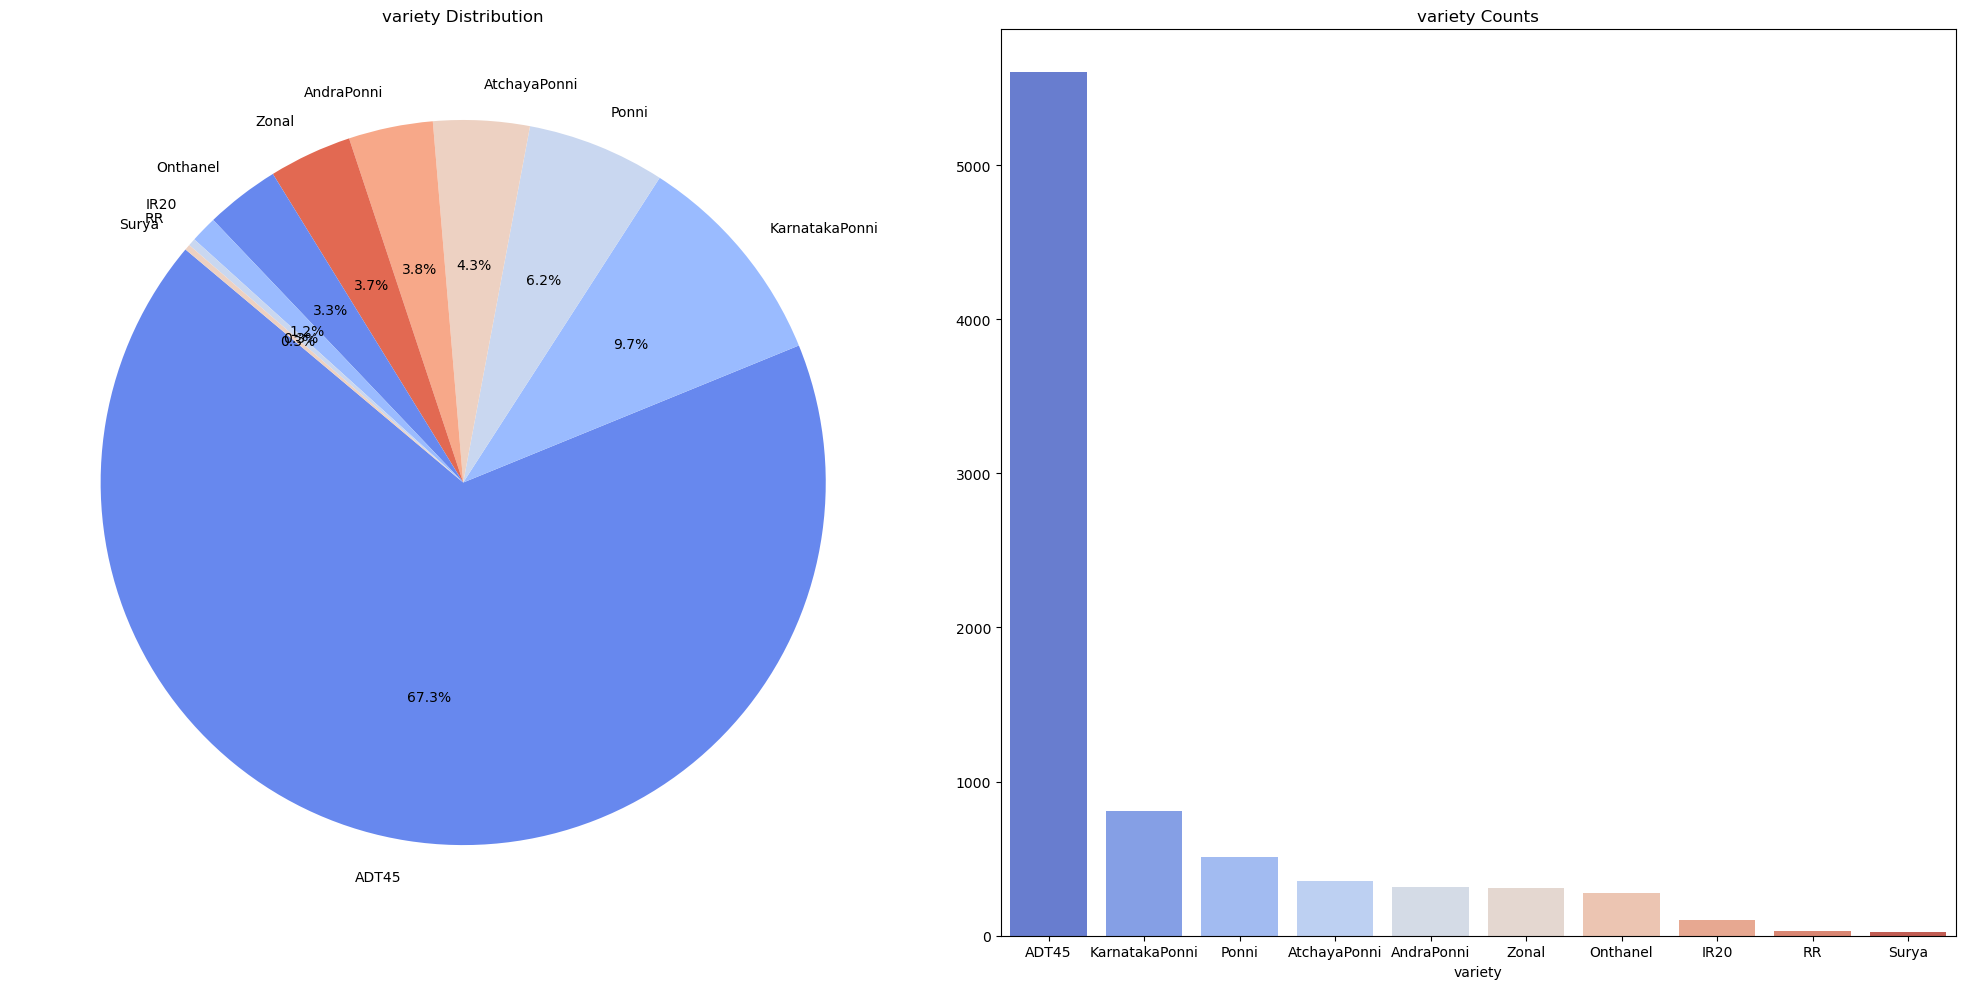

In [21]:
visualize_category_distribution(train_df, "variety")

In [22]:
train_df["variety"].value_counts()

variety
ADT45             5601
KarnatakaPonni     809
Ponni              513
AtchayaPonni       357
AndraPonni         313
Zonal              308
Onthanel           276
IR20                99
RR                  28
Surya               21
Name: count, dtype: int64

#### 3.3) Handle Imbalance in `Variety` Distribution

The above pie chart provides us with the current distribution of the variety, where some varieties like ⁣`Surya`, `RR` , and `IR20` only account for under or equal to 1%, while certain varieties such as `ADT45` dominate the dataset.

To address this issue, we applied some **offline image augmentations** to increase the number of images for minority classes. The intensity of augmentation is based on the frequency tier of each variety. The logic is implemented in the `df_augmentation()` for a simple workflow.

| Tier                          | Variety Names                                     | Applied Augmentations                                                                             |
| ----------------------------- | ------------------------------------------------- | --------------------------------------------------------------------------------------------------|
| **Very Low (< 50 samples)**   | `Surya`, `RR`                                     | Rotation (±5°, ±10°, ±15°), Horizontal Flip, Vertical Flip, Brightness ±20%, Zoom-in Crop, Cutout |
| **Low (50–120 samples)**      | `IR20`                                            | Rotation (±5°, ±10°), Brightness ±20%                                                             |    
| **Mid-Low (120–400 samples)** | `Onthanel`, `AndraPonni`, `Zonal`, `AtchayaPonni` | Rotation (±5°), Random Crop                                                                       |
| **Mid (400–1000 samples)**     | `Ponni`, `KarnatakaPonni`                         | Rotation (±5°)                                                                                    |

With this approach we can diverse training sample for minority class. This preprocessing is expected to improve both accuracy and robustness in **Task 2 (Variety Classification)**


In [25]:
augmented_df, augmented_count = df_augmentation(train_df)

Generating augmentations: 100%|██████████| 8325/8325 [01:42<00:00, 81.04it/s] 

+------------------------------------------+
|           AUGMENTATION SUMMARY           |
+------------------------------------------+
Original dataset: 8325 images
Augmented dataset: 15913 images
Added 7588 augmented images


In [26]:
print_header("Augmentation Summary for Varieties:")
for variety, count in sorted(augmented_count.items(), key=lambda x: x[1], reverse=True):
    original_count = train_df[train_df["variety"] == variety].shape[0]
    new_count = original_count + count
    print(f"- {variety}: +{count} new images (now {new_count} total)")

+---------------------------------------------------------+
|           AUGMENTATION SUMMARY FOR VARIETIES:           |
+---------------------------------------------------------+
- KarnatakaPonni: +1618 new images (now 2427 total)
- AtchayaPonni: +1071 new images (now 1428 total)
- Ponni: +1026 new images (now 1539 total)
- AndraPonni: +939 new images (now 1252 total)
- Zonal: +924 new images (now 1232 total)
- Onthanel: +828 new images (now 1104 total)
- IR20: +594 new images (now 693 total)
- RR: +336 new images (now 364 total)
- Surya: +252 new images (now 273 total)


In [33]:
train_augmented_df = pd.read_csv("inputs/meta_train_augmented.csv")

train_augmented_df

image_id                  label       variety  age  \
0                  109387.jpg                  blast  AtchayaPonni   50   
1                  109428.jpg  bacterial_leaf_blight         ADT45   72   
2                  105846.jpg             brown_spot         ADT45   55   
3                  104475.jpg                  blast         ADT45   70   
4                  102822.jpg  bacterial_leaf_streak         ADT45   68   
...                       ...                    ...           ...  ...   
15908        105389_rot_5.jpg             dead_heart      Onthanel   50   
15909  105389_crop_resize.jpg             dead_heart      Onthanel   50   
15910       108747_rot_-5.jpg                  hispa  AtchayaPonni   65   
15911        108747_rot_5.jpg                  hispa  AtchayaPonni   65   
15912  108747_crop_resize.jpg                  hispa  AtchayaPonni   65   

                                              image_path  
0                 ./inputs/train_images\blast\109387.jpg  
1      ./inputs/train_images\bacterial_leaf_blight\10...  
2            ./inputs/train_images\brown_spot\105846.jpg  
3                 ./inputs/train_images\blast\104475.jpg  
4      ./inputs/train_images\bacterial_leaf_streak\10...  
...                                                  ...  
15908  ./inputs/train_augmented_images\dead_heart\105...  
15909  ./inputs/train_augmented_images\dead_heart\105...  
15910  ./inputs/train_augmented_images\hispa\108747_r...  
15911  ./inputs/train_augmented_images\hispa\108747_r...  
15912  ./inputs/train_augmented_images\hispa\108747_c...  

[15913 rows x 5 columns]

+------------------------------------------------------------------------------------+
|           AUGMENTATION EXAMPLES FOR VERY LOW (<50) TIER - VARIETY: SURYA           |
+------------------------------------------------------------------------------------+


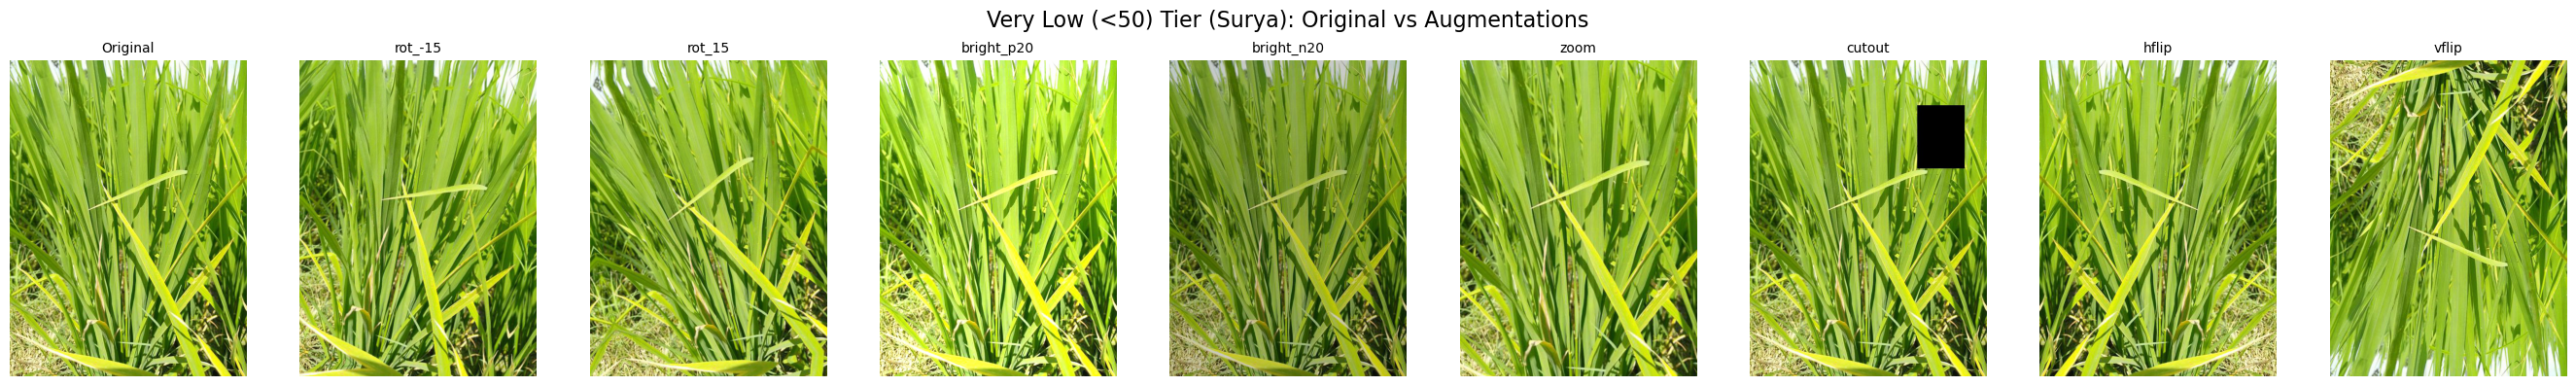

+---------------------------------------------------------------------------------+
|           AUGMENTATION EXAMPLES FOR LOW (50-120) TIER - VARIETY: IR20           |
+---------------------------------------------------------------------------------+


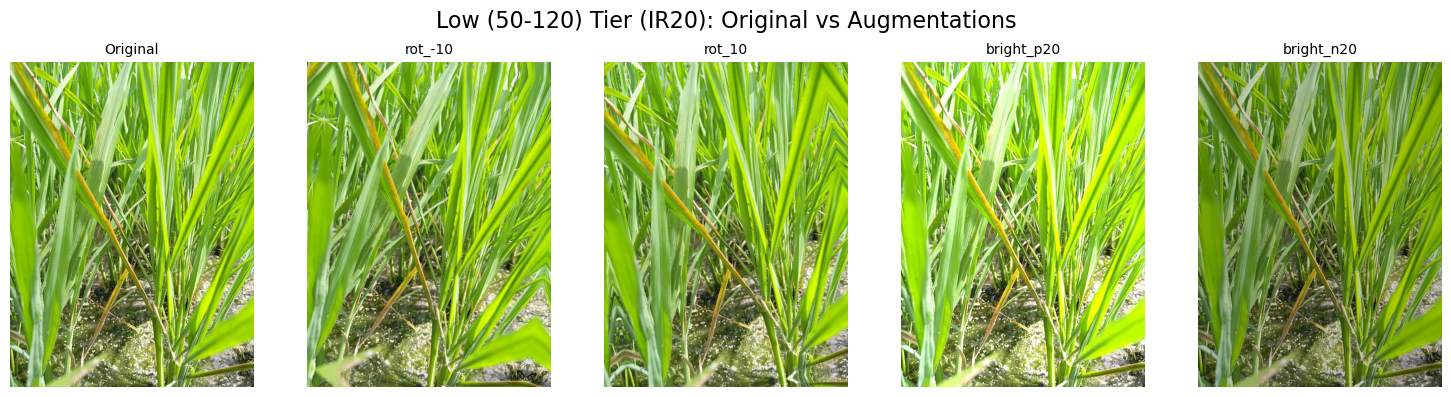

+------------------------------------------------------------------------------------------+
|           AUGMENTATION EXAMPLES FOR MID-LOW (120-400) TIER - VARIETY: ONTHANEL           |
+------------------------------------------------------------------------------------------+


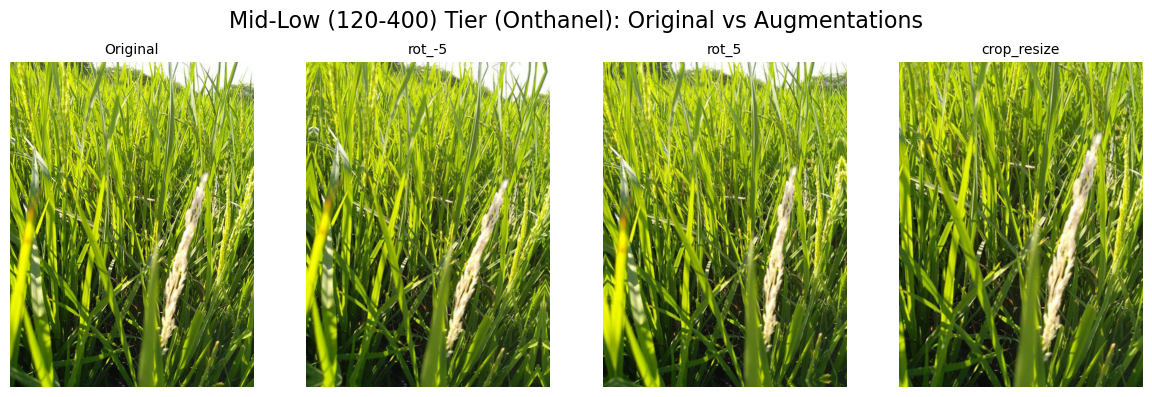

+------------------------------------------------------------------------------------+
|           AUGMENTATION EXAMPLES FOR MID (400-1000) TIER - VARIETY: PONNI           |
+------------------------------------------------------------------------------------+


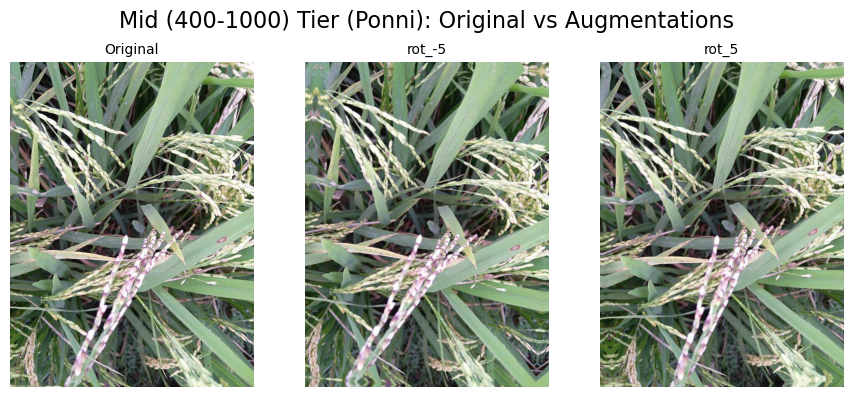

In [35]:
tiers = {
    "Very Low (<50)": ["Surya", "RR"],
    "Low (50-120)": ["IR20"],
    "Mid-Low (120-400)": ["Onthanel", "AndraPonni", "Zonal", "AtchayaPonni"],
    "Mid (400-1000)": ["Ponni", "KarnatakaPonni"],
}

augmentations = {
    "Very Low (<50)": [
        "rot_-15",
        "rot_15",
        "bright_p20",
        "bright_n20",
        "zoom",
        "cutout",
        "hflip",
        "vflip",
    ],
    "Low (50-120)": ["rot_-10", "rot_10", "bright_p20", "bright_n20"],
    "Mid-Low (120-400)": ["rot_-5", "rot_5", "crop_resize"],
    "Mid (400-1000)": ["rot_-5", "rot_5"],
}
display_augmentation_examples(train_df, train_augmented_df, tiers, augmentations)

After applying offline augmentation to minority classes, the variety distribution become **more balanced**. The most dominant class `ADT45` has been reduced from **65%** to only around **35%**, while the percentages of minority classes such as `Surya`, `RR`, and `IR20` have increased their proportions. This adjustments will reduce model bias and enhance accuracy of variety classification in **Task 2**. 

However, the number of maximum variety is 5601 (`ADT45`), while the lowest variety `Surya` is only 273. It is still not enough for models to predict without bias in the domain class. To address the remaining imbalance, we apply **semi-supervised learning** to further expand the dataset.

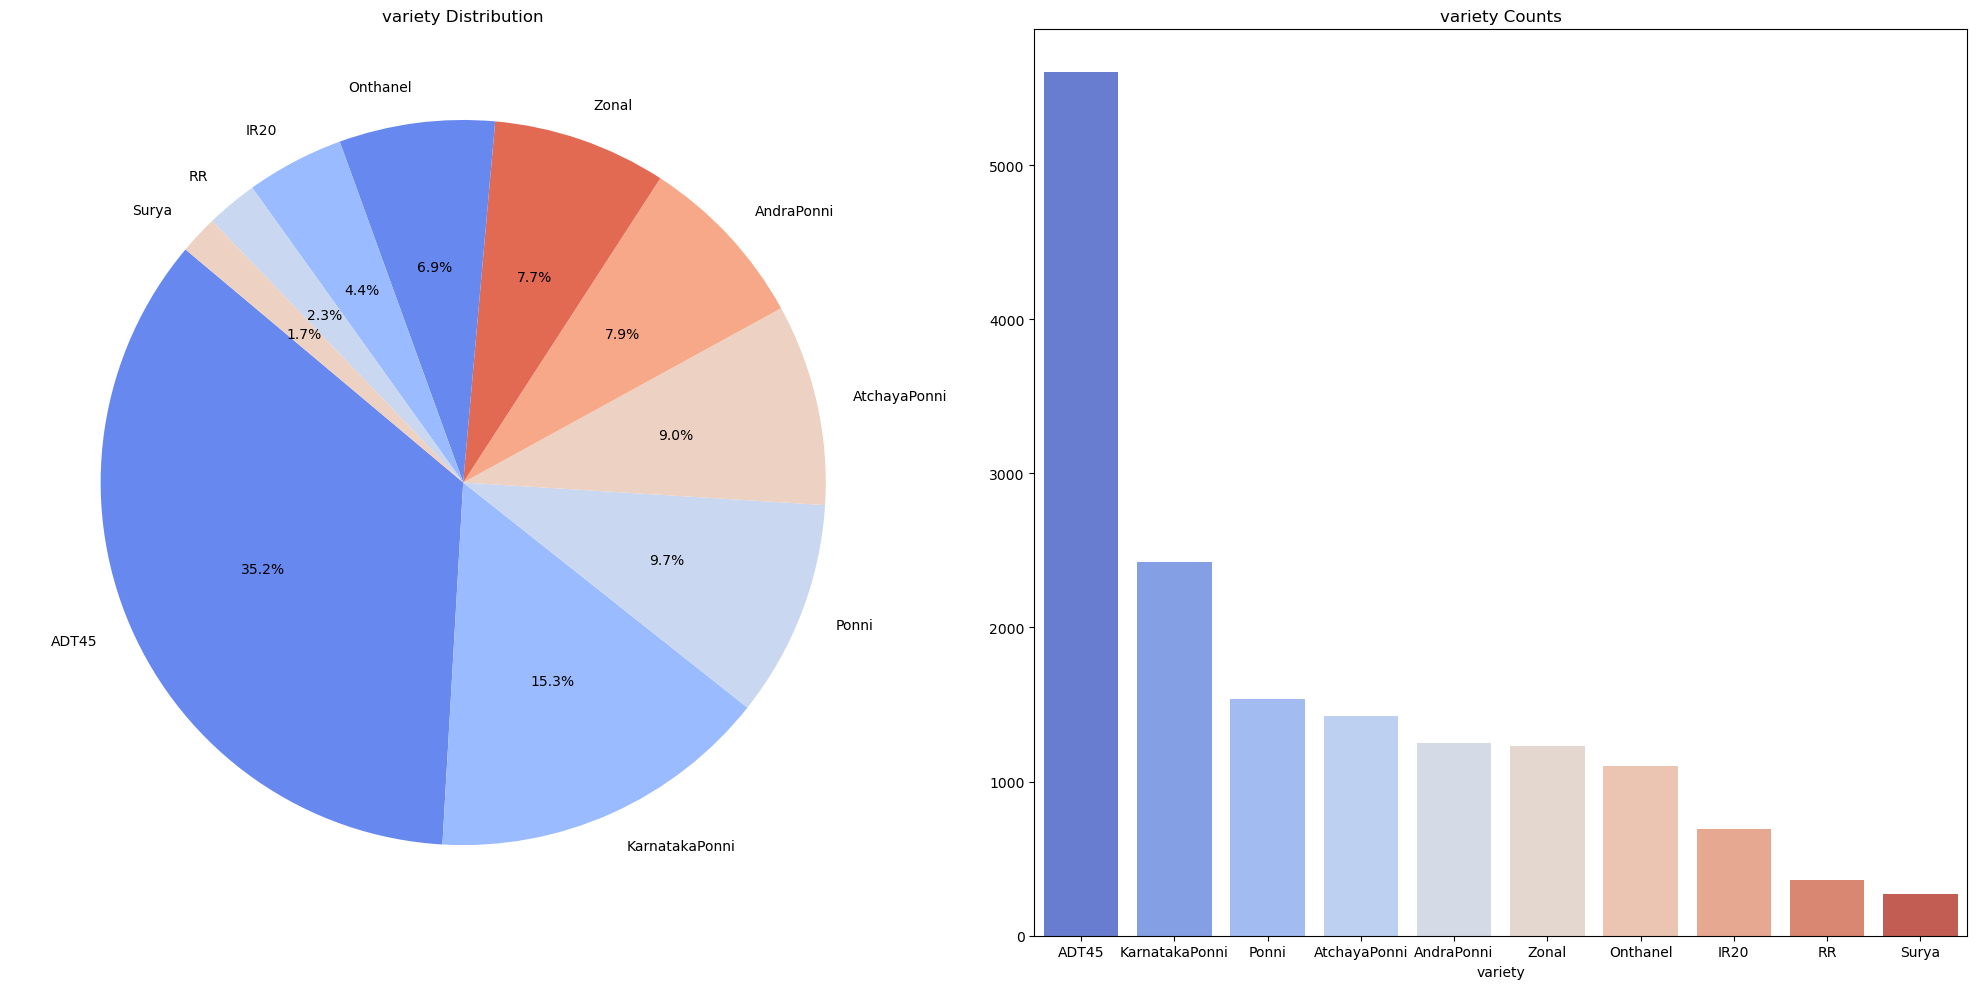

In [36]:
visualize_category_distribution(train_augmented_df, "variety")

In [37]:
print_header("The total number of each variety after augmenting")
train_augmented_df["variety"].value_counts()

+-----------------------------------------------------------------------+
|           THE TOTAL NUMBER OF EACH VARIETY AFTER AUGMENTING           |
+-----------------------------------------------------------------------+


variety
ADT45             5601
KarnatakaPonni    2427
Ponni             1539
AtchayaPonni      1428
AndraPonni        1252
Zonal             1232
Onthanel          1104
IR20               693
RR                 364
Surya              273
Name: count, dtype: int64

#### 3.4) Semi-supervised Learning

define batchsize, input size and output classes

In [31]:
OUTPUT_CLASSES = 10
BATCH_SIZE = 32
INPUT_DIM = (64,64,3)

set train and validation data frame

In [42]:
train_augmented_df['variety'] = train_augmented_df['variety'].astype('str')

combine_variety_df = train_augmented_df.copy()

train_datagen = ImageDataGenerator(data_format='channels_last')
train_generator = train_datagen.flow_from_dataframe(
    dataframe=combine_variety_df,
    directory='',
    x_col='image_path',
    y_col='variety',
    target_size= (64,64),
    batch_size= BATCH_SIZE,
    class_mode='categorical',
    seed=42
)

val_df['variety'] = val_df['variety'].astype('str')
val_datagen = ImageDataGenerator(data_format='channels_last')
val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory= '',
    x_col='image_path',
    y_col='variety',
    target_size=(64, 64),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    seed=42
)
model_variety = Sequential([
    Conv2D(16, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    MaxPooling2D(2, 2),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(10, activation='softmax')
])

model_variety.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


Found 15913 validated image filenames belonging to 10 classes.
Found 2082 validated image filenames belonging to 10 classes.


In [44]:
history = model_variety.fit(
    train_generator, validation_data=val_generator,
    epochs=25,
    verbose=1
)

Epoch 1/25
498/498 [==============================] - 154s 308ms/step - loss: 0.8821 - accuracy: 0.6831 - val_loss: 0.9464 - val_accuracy: 0.6820
Epoch 2/25
498/498 [==============================] - 156s 312ms/step - loss: 0.6960 - accuracy: 0.7491 - val_loss: 0.7361 - val_accuracy: 0.7656
Epoch 3/25
498/498 [==============================] - 127s 255ms/step - loss: 0.5483 - accuracy: 0.7965 - val_loss: 0.7950 - val_accuracy: 0.7363
Epoch 4/25
498/498 [==============================] - 108s 216ms/step - loss: 0.4213 - accuracy: 0.8456 - val_loss: 0.8533 - val_accuracy: 0.7406
Epoch 5/25
498/498 [==============================] - 115s 230ms/step - loss: 0.3222 - accuracy: 0.8839 - val_loss: 0.6386 - val_accuracy: 0.7911
Epoch 6/25
498/498 [==============================] - 215s 431ms/step - loss: 0.2342 - accuracy: 0.9164 - val_loss: 0.5184 - val_accuracy: 0.8377
Epoch 7/25
498/498 [==============================] - ETA: 0s - loss: 0.1729 - accuracy: 0.9407

KeyboardInterrupt: 

In [ ]:
# 4. Setup generator for unlabeled data
unlabeled_datagen = ImageDataGenerator(data_format='channels_last')

# Create a generator for unlabeled data
unlabeled_generator = unlabeled_datagen.flow_from_directory(
    directory='inputs/unlabel',  # Your unlabeled data directory
    target_size=(64, 64),
    batch_size=BATCH_SIZE,
    class_mode=None,  # No labels
    shuffle=False
)
os.makedirs('inputs', exist_ok=True)  # This will create the directory if it doesn't exist

# 5. Generate pseudo-labels for unlabeled data
print("\nGenerating pseudo-labels for unlabeled data...")
# 1. Predict on unlabeled data (already in your code)
predictions = model_variety.predict(unlabeled_generator)
predicted_classes = np.argmax(predictions, axis=1)
confidence_scores = np.max(predictions, axis=1)

# 2. Filter high-confidence predictions
confidence_threshold = 0.9
high_confidence_mask = confidence_scores > confidence_threshold

# 3. Map class indices to variety class names
class_indices = train_generator.class_indices  # Make sure this is defined from your labeled data generator
inv_class_indices = {v: k for k, v in class_indices.items()}
predicted_varieties = [inv_class_indices[idx] for idx in predicted_classes]

# 4. Prepare DataFrame for high-confidence predictions
image_paths = np.array(unlabeled_generator.filenames)
image_ids = [os.path.basename(path) for path in image_paths]

high_confidence_df = pd.DataFrame({
    'image_id': np.array(image_ids)[high_confidence_mask],
    'label': '',  # Unknown for unlabeled data
    'variety': np.array(predicted_varieties)[high_confidence_mask],
    'age': '',    # Unknown for unlabeled data
    'image_path': image_paths[high_confidence_mask]
})

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'inputs/unlabel'

In [ ]:

original_combine_df = train_augmented_df.copy()
added_pseudo_df = pd.DataFrame(columns=original_combine_df.columns)

selected_varieties = ['RR', 'Surya', 'IR20']
confidence_threshold = 0.9

for iteration in range(10):
    print(f"\n=== Iteration {iteration+1} ===")
    
    # 1. Reset combine_df to original + all added so far
    combine_df = pd.concat([original_combine_df, added_pseudo_df], ignore_index=True)
    
    # 2. Update train_generator to use the new combine_df
    train_generator = train_datagen.flow_from_dataframe(
        dataframe=combine_df,
        directory='',
        x_col='image_path',
        y_col='variety',
        target_size=(64, 64),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        seed=42
    )
    
    # 3. Train the model
    model_variety.fit(
        train_generator,
        validation_data=val_generator,
        epochs=1,  
        verbose=1
    )
    
    # 4. Predict on unlabeled data
    predictions = model_variety.predict(unlabeled_generator)
    predicted_classes = np.argmax(predictions, axis=1)
    confidence_scores = np.max(predictions, axis=1)
    
    # 5. Map class indices to variety names
    class_indices = train_generator.class_indices
    inv_class_indices = {v: k for k, v in class_indices.items()}
    predicted_varieties = [inv_class_indices[idx] for idx in predicted_classes]
    
    # 6. Prepare DataFrame for high-confidence predictions
    image_paths = np.array(unlabeled_generator.filepaths)
    image_ids = [os.path.basename(path) for path in image_paths]
    
    high_confidence_mask = confidence_scores > confidence_threshold
    high_confidence_df = pd.DataFrame({
        'image_id': np.array(image_ids)[high_confidence_mask],
        'label': '',  # Unknown for unlabeled data
        'variety': np.array(predicted_varieties)[high_confidence_mask],
        'age': '',    # Unknown for unlabeled data
        'image_path': image_paths[high_confidence_mask]
    })
    
    # 7. Filter for selected varieties
    filtered_df = high_confidence_df[high_confidence_df['variety'].isin(selected_varieties)]
    
    # 8. Remove already-included images
    already_added_ids = set(added_pseudo_df['image_id'])
    filtered_df = filtered_df[~filtered_df['image_id'].isin(already_added_ids)]
    
    # 9. Add to added_pseudo_df
    added_pseudo_df = pd.concat([added_pseudo_df, filtered_df], ignore_index=True)
    
    # 10. Print the newly added rows for this iteration
    print(f"Added {len(filtered_df)} new high-confidence samples:")
    print(filtered_df)

In [ ]:
# After all iterations, save the final combined DataFrame
final_df = pd.concat([original_combine_df, added_pseudo_df], ignore_index=True)
os.makedirs('inputs', exist_ok=True)
final_df.to_csv('inputs/meta_train_semi_supervise.csv', index=False)
print("\nFinal combined DataFrame saved to inputs/meta_train_semi_supervise.csv")

In [ ]:
final_df['variety'] = final_df['variety'].astype('str')

task2_train = ImageDataGenerator(data_format='channels_last')
task2_generator = task2_train.flow_from_dataframe(
    dataframe=final_df,
    directory='',
    x_col='image_path',
    y_col='variety',
    target_size= (64,64),
    batch_size= 32,
    class_mode='categorical',
    seed=42
)

In [ ]:


def analyze_model_layers(model, model_name):
    print(f"\n=== {model_name} Layer Analysis ===")
    print(f"Total number of layers: {len(model.layers)}")

    layer_types = {}
    for layer in model.layers:
        layer_type = layer.__class__.__name__
        layer_types[layer_type] = layer_types.get(layer_type, 0) + 1
    
    print("\nLayer type distribution:")
    for layer_type, count in layer_types.items():
        print(f"{layer_type}: {count}")
    
    # Count trainable parameters
    trainable_params = sum([layer.count_params() for layer in model.layers if layer.trainable])
    print(f"\nTotal trainable parameters: {trainable_params:,}")

# Create base models
efficientnet = EfficientNetB0(
    input_shape=(64, 64, 3),
    include_top=False,
    weights=None
)

resnet = ResNet50(
    input_shape=(64, 64, 3),
    include_top=False,
    weights=None
)

# Analyze both models
analyze_model_layers(efficientnet, "EfficientNetB0")
analyze_model_layers(resnet, "ResNet50")

# Create and analyze the full models with their heads
def create_full_model(base_model, model_name):
    model = models.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
    ])
    return model

efficientnet_full = create_full_model(efficientnet, "EfficientNetB0")
resnet_full = create_full_model(resnet, "ResNet50")

print("\n=== Full Model Analysis (with heads) ===")
analyze_model_layers(efficientnet_full, "EfficientNetB0 Full")
analyze_model_layers(resnet_full, "ResNet50 Full")



=== EfficientNetB0 Layer Analysis ===
Total number of layers: 237

Layer type distribution:
InputLayer: 1
Rescaling: 1
Normalization: 1
ZeroPadding2D: 5
Conv2D: 65
BatchNormalization: 49
Activation: 33
DepthwiseConv2D: 16
GlobalAveragePooling2D: 16
Reshape: 16
Multiply: 16
Dropout: 9
Add: 9

Total trainable parameters: 4,049,571

=== ResNet50 Layer Analysis ===
Total number of layers: 175

Layer type distribution:
InputLayer: 1
ZeroPadding2D: 2
Conv2D: 53
BatchNormalization: 53
Activation: 49
MaxPooling2D: 1
Add: 16

Total trainable parameters: 23,587,712

=== Full Model Analysis (with heads) ===

=== EfficientNetB0 Full Layer Analysis ===
Total number of layers: 4

Layer type distribution:
Functional: 1
GlobalAveragePooling2D: 1
Dense: 2

Total trainable parameters: 4,214,829

=== ResNet50 Full Layer Analysis ===
Total number of layers: 4

Layer type distribution:
Functional: 1
GlobalAveragePooling2D: 1
Dense: 2

Total trainable parameters: 23,851,274


In [ ]:
def create_efficientnetb0_model():
    base_model = tf.keras.applications.EfficientNetB0(
        input_shape=(64, 64, 3),
        include_top=False,
        weights=None,  # Random weights
        pooling='avg'
    )
    model = models.Sequential([
        base_model,
        layers.Dense(10, activation='softmax')
    ])
    return model

# Create and compile model
model = create_efficientnetb0_model()
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',  # <--- change here
    metrics=['accuracy']
)

# Train model
history = model.fit(
    task2_generator,              # generator for training
    validation_data=val_generator, # generator for validation
    epochs=5,
    verbose=2
)

# Save model
model.save('efficientnetb0_paddy_classifier.h5')


In [ ]:
evaluate_model(model, val_generator, "effientNet")

In [ ]:
# from tensorflow.keras.applications import ResNet50


resnet50_model = models.Sequential([
    ResNet50(
        input_shape=(64, 64, 3),
        include_top=False,
        weights=None,  # Random weights
        pooling='avg'
    ),
    layers.Dense(NUM_CLASSES, activation='softmax')
])

resnet50_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',  # matches class_mode='categorical'
    metrics=['accuracy']
)

resnet50_history = resnet50_model.fit(
    task2_generator,
    validation_data=val_generator,
    epochs=5,
    verbose=1
)

resnet50_model.save('resnet50_paddy_classifier.h5')

In [ ]:
def get_metric(history, key_options):
    for key in key_options:
        if key in history.history:
            return history.history[key]
    return None

def plot_history(histories, model_names):
    plt.figure(figsize=(18, 7))

    # Accuracy
    plt.subplot(1, 2, 1)
    for history, name in zip(histories, model_names):
        acc = get_metric(history, ['accuracy', 'acc'])
        val_acc = get_metric(history, ['val_accuracy', 'val_acc'])
        if acc is None or val_acc is None:
            print(f"Warning: Accuracy not found for {name}. Skipping.")
            continue
        epochs = range(1, len(acc) + 1)
        plt.plot(epochs, acc, marker='o', label=f'{name} Train')
        plt.plot(epochs, val_acc, marker='x', linestyle='--', label=f'{name} Val')
        # Annotate best val accuracy
        best_epoch = np.argmax(val_acc)
        best_val = val_acc[best_epoch]
        plt.annotate(f'{best_val:.2%}', (best_epoch+1, best_val), textcoords="offset points", xytext=(0,10), ha='center')
    plt.title('Model Accuracy per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid(True, linestyle=':')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    for history, name in zip(histories, model_names):
        loss = get_metric(history, ['loss'])
        val_loss = get_metric(history, ['val_loss'])
        if loss is None or val_loss is None:
            print(f"Warning: Loss not found for {name}. Skipping.")
            continue
        epochs = range(1, len(loss) + 1)
        plt.plot(epochs, loss, marker='o', label=f'{name} Train')
        plt.plot(epochs, val_loss, marker='x', linestyle='--', label=f'{name} Val')
        # Annotate lowest val loss
        best_epoch = np.argmin(val_loss)
        best_val = val_loss[best_epoch]
        plt.annotate(f'{best_val:.4f}', (best_epoch+1, best_val), textcoords="offset points", xytext=(0,10), ha='center')
    plt.title('Model Loss per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True, linestyle=':')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Usage:
plot_history(
    [history,  resnet50_history],
    ['EfficientNetB0', 'ResNet50']
)

In [ ]:

def plot_roc_curves(models, model_names, test_generator, num_classes):
    plt.figure(figsize=(12, 8))
    
    # Get true labels and predictions for each model
    y_true = test_generator.classes
    y_true_bin = label_binarize(y_true, classes=range(num_classes))
    
    # Plot ROC curve for each model
    for model, name in zip(models, model_names):
        # Get predictions
        y_pred = model.predict(test_generator)
        
        # Compute ROC curve and ROC area for each class
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        
        for i in range(10):
            fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])
        
        # Compute micro-average ROC curve and ROC area
        fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), y_pred.ravel())
        roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
        
        # Plot micro-average ROC curve
        plt.plot(fpr["micro"], tpr["micro"],
                label=f'{name} (AUC = {roc_auc["micro"]:.3f})',
                lw=2)
    
    # Plot diagonal line
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for All Models')
    plt.legend(loc="lower right")
    plt.grid(True, linestyle=':')
    plt.show()


plot_roc_curves(
    [model, resnet50_model],
    ['EfficientNetB0', 'ResNet50'],
    val_generator,
    num_classes= 10
)

In [ ]:
def evaluate_model(model, generator, model_name):
    y_true = generator.classes
    steps = int(np.ceil(generator.samples / generator.batch_size))
    y_pred_probs = model.predict(generator, steps=steps)
    y_pred = np.argmax(y_pred_probs, axis=1)
    
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    
    print(f"--- {model_name} ---")
    print(f"Accuracy : {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall   : {recall:.4f}")
    print(f"F1-score : {f1:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=list(generator.class_indices.keys()), zero_division=0))
    print("\n")

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

# --- Compute balanced class weights ---
# Get the class labels from your generator
class_labels = task2_generator.classes

# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(class_labels),
    y=class_labels
)

# Convert to a dictionary for Keras
class_weight_dict = dict(enumerate(class_weights))

## Fine-Tuned ResNet50 Model Architecture and Training Strategy

### 1. **Base Model: ResNet50**
- **weights='imagenet':** Leverages pretrained weights for better feature extraction, especially useful with limited data.
- **include_top=False, pooling='avg':** Removes the default classifier and uses global average pooling for parameter efficiency.

### 2. **Custom Classification Head**
- **BatchNormalization:** Added after the base and dense layer for stable and faster convergence.
- **Dropout (0.25):** Moderate dropout to reduce overfitting.
- **Dense(64, relu, l2=0.0001):** A single, smaller dense layer for feature learning with mild L2 regularization.
- **Dense(NUM_CLASSES, softmax, l2=0.001):** Output layer for multi-class classification with slightly stronger regularization.

### 3. **Training Strategy**
- **Freeze base model initially:** Only the custom head is trained for a few epochs, preventing large updates to pretrained weights.
- **Unfreeze and fine-tune:** The entire model is then trained with a lower learning rate for a few more epochs, allowing the base to adapt to the new data.
- **Callbacks:** Early stopping, model checkpointing, and learning rate reduction are used for robust training and to prevent overfitting.
- **class_weight:** Addresses class imbalance.

### 4. **Why This Approach?**
- **Transfer learning** with a pretrained base helps the model generalize better and converge faster.
- **Moderate head complexity** and regularization prevent overfitting, especially important for smaller datasets.
- **Progressive unfreezing** allows the model to adapt without catastrophic forgetting.

**Conclusion:**  
This fine-tuned ResNet50 setup balances the power of transfer learning with careful regularization and a simple custom head, making it well-suited for your paddy classification task.